# Calculate sigmav vs. mDM for simulated DM datasets

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u

from gammapy.astro.darkmatter.utils import SigmaVEstimator, DMDatasetOnOff
from gammapy.spectrum import CountsSpectrum
from gammapy.astro.darkmatter import DarkMatterAnnihilationSpectralModel
from gammapy.irf import load_cta_irfs

## Define parameters for simulated observation

In [2]:
# -
livetime = 100 * u.h # in hours
offset = 0.5 * u.deg
FOVLON=0 * u.deg
FOVLAT=0 * u.deg

# Energy from 0.01 to 100 TeV with 20 bins/decade
energy = np.logspace(-1.8, 1.5, 20) * u.TeV

# Energy true wider range and higher number of bins
energy_true = np.logspace(-2, 2, 100) * u.TeV

# DMAnnihilation Model
JFAC = 3.41e19 * u.Unit("GeV2 cm-5") # point source
mDM = 5000*u.Unit("GeV")
channel = "b"
redshift = 0

## Build IRFs with the defined parameters

In [3]:
# Load IRFs
filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
cta_irf = load_cta_irfs(filename)

NDDataArray summary info
MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 42        
	node type  : edges     
	edges min  : 1.3e-02 TeV
	edges max  : 2.0e+02 TeV
	interp     : log       
MapAxis

	name       : offset    
	unit       : 'deg'     
	nbins      : 6         
	node type  : edges     
	edges min  : 0.0e+00 deg
	edges max  : 6.0e+00 deg
	interp     : lin       
Data           : size =   252, min =  0.000 m2, max = 5371581.000 m2



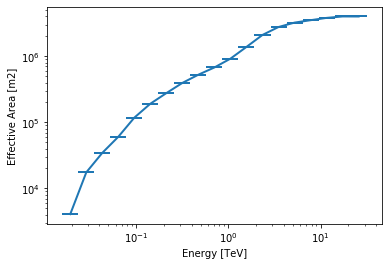

In [4]:
aeff = cta_irf["aeff"].to_effective_area_table(offset=offset, energy=energy)
aeff.plot()
plt.loglog()
print(cta_irf["aeff"].data)

In [5]:
#edisp = cta_irf["edisp"].to_energy_dispersion(
#    offset=offset, e_true=energy_true, e_reco=energy
#)
#edisp.plot_matrix()
#print(edisp.data)

## Build the background counts from PSF and IRF background

In [6]:
containment = 0.68
energies = np.sqrt(energy[1:] * energy[:-1])
psf = cta_irf["psf"].to_energy_dependent_table_psf(theta=offset)
on_radii = psf.containment_radius(energy=energies, fraction=containment)
solid_angles = 2 * np.pi * (1 - np.cos(on_radii)) * u.sr

#
aeff.data.data *= containment

In [7]:
bkg_data = cta_irf["bkg"].evaluate_integrate(
    fov_lon=FOVLON, fov_lat=FOVLAT, energy_reco=energy
)
bkg = CountsSpectrum(
    energy[:-1],
    energy[1:],
    data=(bkg_data * solid_angles).to_value("h-1")*livetime
)

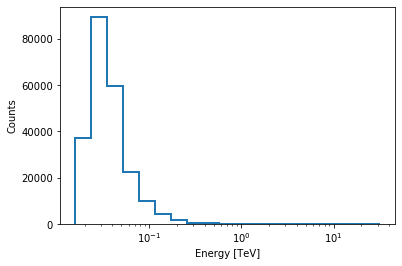

In [8]:
bkg.plot_hist()

## Simulate OnOff observation with DM emission model

In [9]:
# DM Flux
flux_model = DarkMatterAnnihilationSpectralModel(
    mass=mDM, 
    channel=channel, 
    jfactor=JFAC, 
    z=redshift
)

In [10]:
#from gammapy.modeling.models import Absorption, AbsorbedSpectralModel
#absorption_model = Absorption.read_builtin('dominguez')
#flux_model = AbsorbedSpectralModel(flux_model, absorption_model, redshift)

In [12]:
dataset = DMDatasetOnOff(
    aeff=aeff,
    model=flux_model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)

In [13]:
nuissance = dict(
    j=JFAC,
    jobs=JFAC,
    sigmaj=0.1*JFAC,
    #width=5,
    #steps=15,
)
dataset.nuissance = nuissance
#dataset.check_nuissance() is True if valid values for nuissance are defined in the dataset.

**Enable inspection**

In [15]:
import logging
logging.basicConfig()
logging.getLogger("gammapy.astro.darkmatter.utils").setLevel("WARNING")
#logging.getLogger("gammapy.astro.darkmatter.utils").setLevel("DEBUG")

**The SigmaVEstimator class estimates $\sigma\nu$ for a list of annihilation channels and particle masses.**

In order to have statistics the overall process below is repeated for a given number of `runs`.

- For each run a **random poisson realization** of a `DMDatasetOnOff` is created as a simulated observation.
- For each run we consider a list of annihilation channels.
    - For each channel we consider a list of masses.
        - For each mass in each channel:
            - A specific `DarkMatterAnnihilationSpectralModel` is instantiated with parameters `JFactor`, `channel`, `mass`.
            - This specific annhilation flux model is attached to the `DMDatasetOnOff` dataset instance.
            - A fit of this specific annhilation model to the simulated observation of the run is performed for each of the `steps` values that the nuissance parameter `j` takes in a range of ± `sigmaj` * `width`. 
            - A fit is chosen: the one giving the minimum value for the likelihood.
            - A check (L<sub>min</sub> - L<sub>0</sub> ≤ 25) is done.
            - A value of the scale parameter `sv` giving ΔL=2.71 in the likelihood profile is chosen.
            - If the value of `sv` is not in the range of the physical region (>=0) or does not reach ΔL=2.71 we skip the run and take the next one.
            -  $\sigma\nu$  is the chosen value of `sv`is multiplied by the thermal relic cross section.

- Profile likelihoods and values calculated for `sv` and $\sigma\nu$ are provided for each run, channel and mass.
- For each channel a table of mean values across all runs of $\sigma\nu$ vs. mass is provided. 
- Messages are displayed according to the logging level sonfiguration defined.

**Instatiate estimator**

In [16]:
masses = [100, 200, 500, 1000, 5000, 10000, 50000]*u.GeV
channels = ["b", "tau", "Z"] 
estimator = SigmaVEstimator(dataset, masses, channels, background_model=bkg, jfactor=JFAC)

**Run estimator and fetch results**

In [17]:
%%time
#likelihood_profile_opts=dict(bounds=50, nvalues=50)
result = estimator.run(runs=10, nuissance=True)
#if nuissance = True the process takes the nuissance parameters into account.

CPU times: user 7min 19s, sys: 5.09 s, total: 7min 25s
Wall time: 7min 33s


## Inspection of results

**Display results for channel b and run 0**

In [18]:
cols = ["mass", "sigma_v", "sv_best", "sv_ul", "likeprofile"]
result["runs"]["b"][0][cols]

mass,sigma_v,sv_best,sv_ul,likeprofile
GeV,cm3 / s,,,
float64,float64,float64,float64,object
100.0,1.2216477909002988e-24,0.0,40.721593030009956,"{'values': array([-2765.677084 , -2652.9992272 , -2540.32137039, -2427.64351359, -2314.96565679, -2202.28779999, -2089.60994319, -1976.93208638, -1864.25422958, -1751.57637278, -1638.89851598, -1526.22065918, -1413.54280237, -1300.86494557, -1188.18708877, -1075.50923197, -962.83137516, -850.15351836, -737.47566156, -624.79780476, -512.11994796, -399.44209115, -286.76423435, -174.08637755, -61.40852075, 51.26933606, 163.94719286, 276.62504966, 389.30290646, 501.98076326, 614.65862007, 727.33647687, 840.01433367, 952.69219047, 1065.37004727, 1178.04790408, 1290.72576088, 1403.40361768, 1516.08147448, 1628.75933129, 1741.43718809, 1854.11504489, 1966.79290169, 2079.47075849, 2192.1486153 , 2304.8264721 , 2417.5043289 , 2530.1821857 , 2642.86004251, 2755.53789931]), 'likelihood': array([11943.41202171, 10940.82470085, 9986.47555001, 9079.84653076, 8220.42322803, 7407.69543455, 6641.1574707 , 5920.30810147, 5244.64985089, 4613.68746158, 4026.92526946, 3483.86345564, 2983.99348823, 2526.79320191, 2111.71031425, 1738.10781839, 1405.35442776, 1112.77856268, 859.65382258, 645.20438096, 468.62097902, 329.02060936, 225.53353235, 157.32969906, 123.60121405, 123.57032401, 156.49589146, 221.67555901, 318.4440938 , 446.17002949, 604.25205089, 792.11569916, 1009.21053784, 1255.00776118, 1528.99818282, 1830.69053955, 2159.61005214, 2515.29719562, 2897.30664019, 3305.20633203, 3738.57668889, 4197.00989101, 4680.10925105, 5187.4886505 , 5718.77203198, 6273.59293904, 6851.59409651, 7452.42702571, 8075.75168993, 8721.23616606])}"
200.0,7.524331551033384e-25,0.0,25.08110517011128,"{'values': array([-1698.10069576, -1628.91375186, -1559.72680796, -1490.53986406, -1421.35292016, -1352.16597625, -1282.97903235, -1213.79208845, -1144.60514455, -1075.41820065, -1006.23125674, -937.04431284, -867.85736894, -798.67042504, -729.48348114, -660.29653724, -591.10959333, -521.92264943, -452.73570553, -383.54876163, -314.36181773, -245.17487382, -175.98792992, -106.80098602, -37.61404212, 31.57290178, 100.75984568, 169.94678959, 239.13373349, 308.32067739, 377.50762129, 446.69456519, 515.8815091 , 585.068453 , 654.2553969 , 723.4423408 , 792.6292847 , 861.8162286 , 931.00317251, 1000.19011641, 1069.37706031, 1138.56400421, 1207.75094811, 1276.93789201, 1346.12483592, 1415.31177982, 1484.49872372, 1553.68566762, 1622.87261152, 1692.05955543]), 'likelihood': array([11582.7790906 , 10624.56392508, 9710.89341477, 8841.37643726, 8015.63064795, 7233.28311417, 6493.97089861, 5797.34148954, 5143.05288939, 4530.77303941, 3960.178065 , 3430.94860897, 2942.7634413 , 2495.29000858, 2088.17303532, 1721.02393327, 1393.4132906 , 1104.86249035, 854.72667378, 642.34859507, 467.08251094, 328.27593683, 225.26993651, 157.27603168, 123.60108071, 123.5741585 , 156.55071507, 221.92643645, 319.13691266, 447.65186937, 606.96936995, 796.61118618, 1016.11925214, 1265.05293441, 1542.98689764, 1849.50940818, 2184.22096542, 2546.73318264, 2936.66786075, 3353.65621331, 3797.3382113 , 4267.36202403, 4763.3835376 , 5285.06593678, 5832.0793388 , 6404.10047028, 7000.81238005, 7621.90418207, 8267.07082372, 8936.01287573])}"
500.0,5.706485093090071e-25,0.0,19.021616976966904,"{'values': array([-1162.52002565, -1115.07654475, -1067.63306385, -1020.18958295, -972.74610205, -925.30262115, -877.85914025, -830.41565935, -782.97217845, -735.52869755, -688.08521665, -640.64173575, -593.19825485, -545.75477395, -498.31129305, -450.86781215, -403.42433125, -355.98085035, -308.53736945, -261.09388855, -213.65040764, -166.20692674, -118.76344584, -71.31996494, -23.87648404, 23.56699686, 71.01047776, 118.45395866, 165.89743956, 213.34092046, 260.78440136, 308.22788226, 355.67136316, 403.11484406, 450.55832496, 498.00180586, 545.44528676, 592.88876766, 640.33224856, 687.77572946, 735.21921036, 782.66269126, 830.10617216, 877.54965306, 924.99313396, 972.43661487, 101

**Plot likelihood profile for a specific fit**

In [19]:
idx = np.argwhere(masses.value==100)
profile = result["runs"]["b"][0]["likeprofile"][idx][0][0]

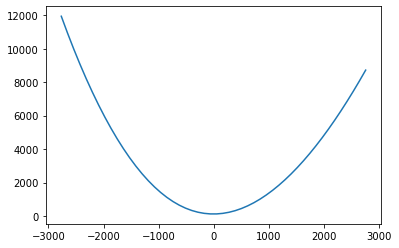

In [20]:
plt.plot(profile["values"], profile["likelihood"]);

## Plot obtained results for sigma

In [21]:
result["mean"]["b"]

mass,sigma_v,std
GeV,cm3 / s,cm3 / s
float64,float64,float64
100.0,1.2715046149334289e-24,3.306713484125295e-25
200.0,8.236691518156498e-25,2.085313789469468e-25
500.0,5.938996787881568e-25,2.30992622679511e-25
1000.0,4.9482862553403325e-25,2.2151164675803526e-25
5000.0,4.488220702547062e-25,1.7103651388207013e-25
10000.0,5.521706365479471e-25,2.3799852762832977e-25
50000.0,1.3252882348644033e-24,5.169988777805491e-25


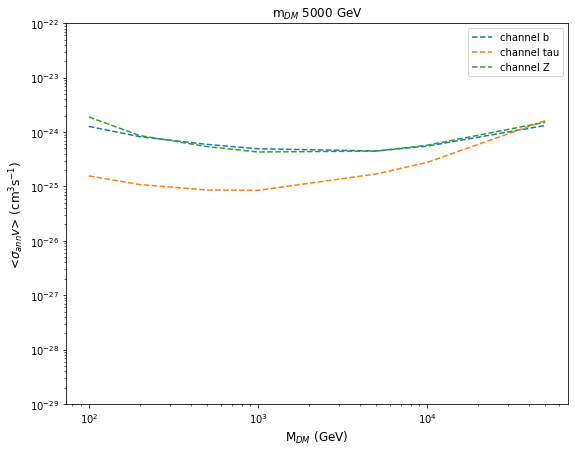

In [22]:
plt.figure(figsize=(9,7))
plt.ylim(1e-29, 1e-22)
plt.ylabel(r"<$\sigma_{ann}v$> (cm$^3$s$^{-1}$)", fontsize=12)
plt.xlabel("M$_{DM}$ (GeV)", fontsize=12)
plt.title('m$_{DM}$ 5000 GeV')

for ch in channels:
    plt.loglog(
        result["mean"][ch]["mass"].data,
        result["mean"][ch]["sigma_v"].data,
        ls="--",
        label='channel {}'.format(ch)
       )
plt.legend();